In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import pandas as pd
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample

 # Load data

In [2]:
label_order = [
   
    "granite",
    "pegmatite",
    "greisen",
     "porphyry",
     "skarn",
     "IRG",
    "orogenic",
    "epithermal",
    "carlin",
]

data = pd.read_excel("quartz_trace_elements.xlsx")
df = data.loc[:, ["qtype", "Al", "Ti", "Li", "Ge", "Sr"]]  # "Al / Li", "Al / atomic mass of Al + Li / atomic mass of Li""

for col_i in range(1, 6):
    df.iloc[:, col_i] = pd.to_numeric(df.iloc[:, col_i], errors="coerce")
df.dropna(inplace=True)

epithermal = df.loc[df['qtype']=='epithermal', :]
print(epithermal.describe())

X = df.copy(deep=True)


                Al         Ti         Li         Ge         Sr
count    26.000000  26.000000  26.000000  26.000000  26.000000
mean   1143.540170   3.267885   3.428393   5.324747   0.128735
std     526.248141   2.287675   2.789890   1.861824   0.243599
min      54.044429   0.665000   0.690000   2.400000   0.010000
25%     852.250000   1.900000   1.450000   3.725000   0.010000
50%    1223.500000   2.750000   2.500000   5.100000   0.025000
75%    1573.750000   3.950000   4.275000   6.700000   0.117500
max    2098.000000  12.000000  12.400000   9.000000   0.940000


In [3]:
def my_resample(n_samples=None, data=df, random_state=0, target='qtype'):
    if n_samples == None:
        n_samples = 26
#     if  data:
#         global df
#         data = df
    upsampled = []
    if target == 'qtype':
        for qtype in ['epithermal', 'pegmatite', 'IRG', 'carlin','orogenic', 'greisen', 'porphyry', 'granite', 'skarn']:
            tem = data.loc[data['qtype']==qtype, :]
            upsampled.append(resample(tem, n_samples=n_samples, random_state=random_state))  
    else:
        for qtype in range(9):
            tem = data.loc[data['label']==qtype, :]
            upsampled.append(resample(tem, n_samples=n_samples, random_state=random_state)) 
    upsampled_cat = pd.concat(upsampled)
    labels = upsampled_cat#.pop('qtype')
    return upsampled_cat #,labels

test = my_resample(100)
# test

In [4]:
# upsampled = []
# for qtype in ['epithermal', 'pegmatite', 'IRG', 'carlin']:
#     tem = X.loc[X['qtype']==qtype, :]
#     upsampled.append(resample(tem, n_samples=200, random_state=0))  
# upsampled_cat = pd.concat(upsampled)
# X = pd.concat([X.loc[X['qtype']=='orogenic', :],
#                X.loc[X['qtype']=='greisen', :],
#                X.loc[X['qtype']=='porphyry', :],
#                X.loc[X['qtype']=='granite', :],
#                X.loc[X['qtype']=='skarn', :],
#                upsampled_cat])


In [5]:
y = X.pop('qtype')
print(y.value_counts())  # number of samples in each class
y_int, index = pd.factorize(y, sort=True)
y = y_int
index
# print(len(X))  # number of samples
# print(y.value_counts()) # number of samples in each class

orogenic      339
greisen       325
porphyry      272
granite       237
skarn         203
carlin        127
IRG            96
pegmatite      65
epithermal     26
Name: qtype, dtype: int64


Index(['IRG', 'carlin', 'epithermal', 'granite', 'greisen', 'orogenic',
       'pegmatite', 'porphyry', 'skarn'],
      dtype='object')

In [6]:
# split the data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# samples in test set for each class
# y_test.value_counts()


In [7]:
# # Upsapling on training set

# X_train['label'] = y_train
# # X_train = my_resample(n_samples=150, data=X_train, random_state=0, target='label')
# upsampled = []

# peg = X_train.loc[X_train['label']==0, :]
# upsampled.append(resample(peg, n_samples=40, random_state=0))
# epi = X_train.loc[X_train['label']==7, :]
# upsampled.append(resample(epi, n_samples=80, random_state=0))
# upsampled_cat = pd.concat(upsampled)



# X_train = pd.concat([X_train, upsampled_cat])
# y_train = X_train.pop('label')
# y_train.value_counts()

# Compare algorithms

In [8]:
X_compare = np.log(X_train)
X_compare = StandardScaler().fit_transform(X_compare)
C = 1
models = (
          svm.SVC(kernel='linear', C=C, class_weight=None),
#           svm.LinearSVC(C=C)
          KNeighborsClassifier(),
          RandomForestClassifier(),
#           svm.SVC(kernel='poly', degree=3, gamma='auto', C=C, class_weight='balanced'),
          svm.SVC(kernel='rbf', C=C), #, class_weight='balanced'),
          MLPClassifier(alpha=0.1),#16, max_iter=2000
         )
for clf in models:
    scores = cross_val_score(clf, X_compare, y_train, cv=5, scoring='f1_macro', n_jobs=-1)
    print(f'{scores.mean():2.2f}' + '±' + f'{scores.std():2.2f}')

0.69±0.03
0.83±0.03
0.83±0.03
0.81±0.02
0.78±0.02


 # Make Pipeline

In [9]:
log_transformer = FunctionTransformer(np.log, validate=True)
pipe_clf = make_pipeline(log_transformer, StandardScaler(), SVC(cache_size=1000, class_weight=None, probability=True))
pipe_clf


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<ufunc 'log'>, validate=True)),
                ('standardscaler', StandardScaler()),
                ('svc', SVC(cache_size=1000, probability=True))])

 # Parameter estimation using grid search with cross-validation and retrain


In [10]:
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


In [11]:
C_range = np.logspace(-2, 9, 12, base=2)
gamma_range = np.logspace(-7, 4, 12, base=2)

param_grid = {"svc__kernel": ["rbf"], "svc__gamma": gamma_range, "svc__C": C_range}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=2)
print(C_range)

[2.50e-01 5.00e-01 1.00e+00 2.00e+00 4.00e+00 8.00e+00 1.60e+01 3.20e+01
 6.40e+01 1.28e+02 2.56e+02 5.12e+02]


In [12]:
grid = GridSearchCV(
    pipe_clf, param_grid=param_grid, cv=10, scoring="f1_macro", n_jobs=-1, refit=True
)
grid.fit(X_train, y_train)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

The best parameters are {'svc__C': 2.0, 'svc__gamma': 0.5, 'svc__kernel': 'rbf'} with a score of 0.85


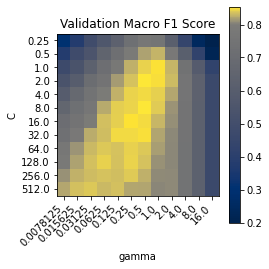

In [13]:
# Visualization
"""
Grid search for the combination of SVM cost parameter (C) and kernel width  
that maximizes 10-fold cross-validation accuracy when classifying rock types.
"""

scores = grid.cv_results_["mean_test_score"].reshape(len(C_range), len(gamma_range))
plt.figure(figsize=(3.75, 3.75))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.cividis,
    norm=MidpointNormalize(vmin=0.2, midpoint=0.8),
)
plt.xlabel("gamma")
plt.ylabel("C")
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45, ha="right")
plt.yticks(np.arange(len(C_range)), C_range)
plt.title("Validation Macro F1 Score")
plt.savefig('heatmap.pdf', dpi=300)
plt.savefig('heatmap.png', dpi=300)
plt.show()


 # Report


In [14]:
y_test_pred = grid.predict(X_test)
t_train_pred = grid.predict(X_train)

In [15]:
# train set report
print(classification_report(y_train, t_train_pred))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87        78
           1       0.97      0.99      0.98        98
           2       1.00      1.00      1.00        20
           3       0.88      0.97      0.92       188
           4       0.89      0.87      0.88       265
           5       0.94      0.90      0.92       262
           6       0.93      0.83      0.88        60
           7       0.91      0.94      0.93       217
           8       0.90      0.81      0.85       164

    accuracy                           0.91      1352
   macro avg       0.92      0.92      0.91      1352
weighted avg       0.91      0.91      0.91      1352



              precision    recall  f1-score   support

           0       0.70      0.78      0.74        18
           1       1.00      0.97      0.98        29
           2       1.00      0.83      0.91         6
           3       0.90      0.88      0.89        49
           4       0.80      0.87      0.83        60
           5       0.85      0.83      0.84        77
           6       0.67      0.80      0.73         5
           7       0.94      0.91      0.93        55
           8       0.76      0.74      0.75        39

    accuracy                           0.86       338
   macro avg       0.85      0.84      0.84       338
weighted avg       0.86      0.86      0.86       338

[[14  0  0  0  0  2  0  2  0]
 [ 0 28  0  0  0  1  0  0  0]
 [ 1  0  5  0  0  0  0  0  0]
 [ 0  0  0 43  4  0  2  0  0]
 [ 0  0  0  3 52  2  0  0  3]
 [ 3  0  0  0  5 64  0  0  5]
 [ 0  0  0  1  0  0  4  0  0]
 [ 0  0  0  1  2  1  0 50  1]
 [ 2  0  0  0  2  5  0  1 29]]


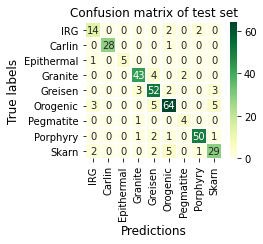

In [16]:
# final evaluation
print(classification_report(y_test, y_test_pred, output_dict=False))
print(confusion_matrix(y_test, y_test_pred))

# heatmap the confusion matrix of test data
# ---------------------------------------------------------------------
label_order = [
    "IRG",
    "carlin",
    "epithermal",
    "granite",
    "greisen",
    "orogenic",
    "pegmatite",
    "porphyry",
    "skarn",
]
for i in range(len(label_order)):
    if label_order[i] == "IRG":
        pass
    else:
        label_order[i] = label_order[i].capitalize()
        
index = list(index)
for i in range(len(index)):
    if index[i] == "IRG":
        pass
    else:
        tem = index[i].capitalize()
        index[i] = tem
# -------------------------------------------------------------------
cm = pd.DataFrame(
    confusion_matrix(y_test, y_test_pred), columns=index, index=index
)

f, ax = plt.subplots(figsize=(3.75, 3.5))
sns.heatmap(cm, annot=True, fmt="d", linewidths=0.5, ax=ax, cmap="YlGn")
ax.set_title("Confusion matrix of test set", fontsize=12)
ax.set_xlabel("Predictions", fontsize=12)
ax.set_ylabel("True labels", fontsize=12)

plt.xticks(rotation=90)
plt.tight_layout()
# f.suptitle('Fig. 5', x=0.05)
f.savefig('./confusion_matrix.png', dpi=300)
f.savefig('./confusion_matrix.pdf', dpi=300)


 # Model persistence

In [17]:
from joblib import dump
import pickle

dump(grid, "quartz_clf.joblib")

with open('quartz_clf.pkl', 'wb') as file:
    pickle.dump(grid, file)


# Decision regions

                Al           Ti           Li           Ge           Sr
count  1690.000000  1690.000000  1690.000000  1690.000000  1690.000000
mean    458.278805    10.351195    22.974302     2.748185     1.117515
std     713.740579    14.775312    66.724120     2.901546     2.998369
min       3.860000     0.005280     0.030000     0.100000     0.000500
25%      79.844400     1.302500     0.790000     1.300000     0.050700
50%     168.235000     4.685000     3.475000     1.820000     0.117750
75%     465.000000    12.762250    18.300000     2.866450     0.683000
max    4205.080000   141.000000   786.900000    35.855000    54.280000


c:\users\yuwan\scoop\apps\python\3.9.1\lib\site-packages\mlxtend\plotting\decision_regions.py:322: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  ax.scatter(x_data,


['IRG',
 'Carlin',
 'Epithermal',
 'Granite',
 'Greisen',
 'Orogenic',
 'Pegmatite',
 'Porphyry',
 'Skarn']

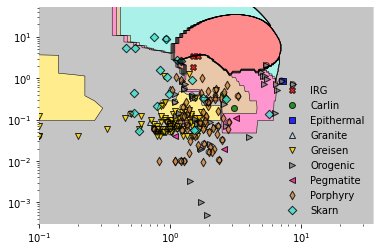

In [18]:
from mlxtend.plotting import plot_decision_regions

colors= ['r'   , 'g'       ,'blueviolet',
         'gold', 'deeppink', 'turquoise',
         'gray', 'b'       , 'peru']

color = 'r,g,b,lightblue,gold,gray,deeppink,peru,turquoise'
markers = ['X','o','s','^','v','>','<','d', 'D', '*']
scatter_kwargs = {'s': 20, 'edgecolor': None, 'alpha': 0.8}
contourf_kwargs = {'alpha': 0.5}
scatter_highlight_kwargs = {'s': 30, 'label': 'Test data', 'alpha': 0.7}

# X = my_resample(100, random_state=42)
# y = X.pop('qtype')
X_np = np.array(X)
# y_int = np.array(pd.factorize(y)[0])
# Plotting decision regions
fig, ax = plt.subplots()
# Decision region for feature 3 = 1.5
value = 1.5
# Plot training sample with feature 3 = 1.5 +/- 0.75
width = 20
# print(classification_report(y, grid.predict(X)))
print(X.describe())
plot_decision_regions(X_np, y_int, clf=grid,
                      feature_index = [3, 4],
                      filler_feature_values={2: 2, 1: 13, 0: 52},
                      filler_feature_ranges={2: width, 1: width, 0: width},
                      legend=2, colors=color, markers=markers,
                      zoom_factor = 5000,
                      X_highlight=np.array(X_test),
#                       scatter_kwargs=scatter_kwargs,
#                       contourf_kwargs=contourf_kwargs,
                      scatter_highlight_kwargs=scatter_highlight_kwargs,
                      ax=ax)
# ax.set(xlim=[0,10], ylim=[0,10])
ax.set(yscale='log', xscale='log')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, 
          index, 
           framealpha=0.0, scatterpoints=1)
index

                Al           Ti           Li           Ge           Sr
count  1690.000000  1690.000000  1690.000000  1690.000000  1690.000000
mean    458.278805    10.351195    22.974302     2.748185     1.117515
std     713.740579    14.775312    66.724120     2.901546     2.998369
min       3.860000     0.005280     0.030000     0.100000     0.000500
25%      79.844400     1.302500     0.790000     1.300000     0.050700
50%     168.235000     4.685000     3.475000     1.820000     0.117750
75%     465.000000    12.762250    18.300000     2.866450     0.683000
max    4205.080000   141.000000   786.900000    35.855000    54.280000


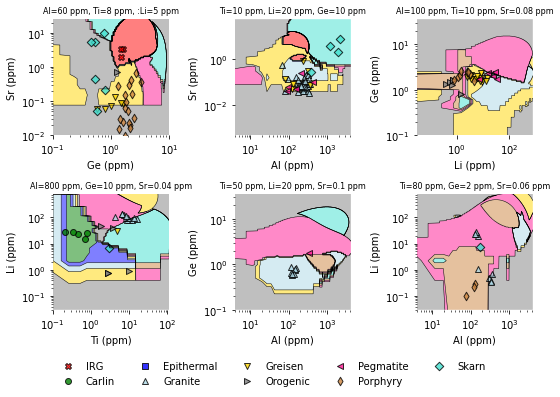

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(7.6,5))
(ax1, ax2, ax3, ax4, ax5, ax6) = axes.flatten()

# Decision region for feature 3 = 1.5
value = 1.5
# Plot training sample with feature 3 = 1.5 +/- 0.75
width = 10
# print(classification_report(y, grid.predict(X)))
print(X.describe())
# 0: 236, 1:7, 2:8, 3:2, 4:0.1, 
#ax1 
plot_decision_regions(X_np, y_int, clf=grid,
                      feature_index = [3, 4],
                      filler_feature_values={2: 5, 1: 8, 0: 60},
                      filler_feature_ranges={2: 5, 1: 5, 0: width},
                      legend=0, colors=color, markers=markers,
                      zoom_factor = 50000,
#                       X_highlight=np.array(X_test),
#                       scatter_kwargs=scatter_kwargs,
                      contourf_kwargs=contourf_kwargs,
#                       scatter_highlight_kwargs=scatter_highlight_kwargs,
                      ax=ax1)
ax1.set(xlim=[1e-1,1e1], ylim=[1e-2,25])
ax1.set_title('Al=60 ppm, Ti=8 ppm, :Li=5 ppm', fontsize=8)
ax1.set_xlabel('Ge (ppm)')
ax1.set_ylabel('Sr (ppm)')

#ax2
plot_decision_regions(X_np, y_int, clf=grid,
                      feature_index = [0, 4],
                      filler_feature_values={ 2: 20, 3:2, 1: 10, }, # 0: 200,  4:0.08
                      filler_feature_ranges={2: 5,  3: 5, 1: 5}, # 1: width, 0: width,
                      legend=0, colors=color, markers=markers,
                      zoom_factor = 50000,
#                       X_highlight=np.array(X_test),
#                       scatter_kwargs=scatter_kwargs,
                      contourf_kwargs=contourf_kwargs,
#                       scatter_highlight_kwargs=scatter_highlight_kwargs,
                      ax=ax2)
ax2.set_title('Ti=10 ppm, Li=20 ppm, Ge=10 ppm', fontsize=8)
ax2.set_xlabel('Al (ppm)')
ax2.set_ylabel('Sr (ppm)')

#ax3
plot_decision_regions(X_np, y_int, clf=grid,
                      feature_index = [2, 3],
                      filler_feature_values={1: 10,    0: 100,    4:0.08}, #   2: 20, 3:2,
                      filler_feature_ranges={1: 5, 0: width,  4: 5}, # 2: width,  3: width,
                      legend=0, colors=color, markers=markers,
                      zoom_factor = 50000,
#                       X_highlight=np.array(X_test),
#                       scatter_kwargs=scatter_kwargs,
                      contourf_kwargs=contourf_kwargs,
#                       scatter_highlight_kwargs=scatter_highlight_kwargs,
                      ax=ax3)
ax3.set_title('Al=100 ppm, Ti=10 ppm, Sr=0.08 ppm', fontsize=8)
ax3.set_xlabel('Li (ppm)')
ax3.set_ylabel('Ge (ppm)')

#ax4
plot_decision_regions(X_np, y_int, clf=grid,
                      feature_index = [1, 2],
                      filler_feature_values={ 0:800, 3:10, 4:0.04}, # 0: 1333,  1: 2,
                      filler_feature_ranges={0: 20,  4: 20, 3: 20}, # 1: width, 0: width,
                      legend=0, colors=color, markers=markers,
                      zoom_factor = 50000,
#                       X_highlight=np.array(X_test),
#                       scatter_kwargs=scatter_kwargs,
                      contourf_kwargs=contourf_kwargs,
#                       scatter_highlight_kwargs=scatter_highlight_kwargs,
                      ax=ax4)
ax4.set_title('Al=800 ppm, Ge=10 ppm, Sr=0.04 ppm', fontsize=8)
ax4.set_xlabel('Ti (ppm)')
ax4.set_ylabel('Li (ppm)')
ax4.set(xlim=[1e-1,110])
#ax5
plot_decision_regions(X_np, y_int, clf=grid,
                      feature_index = [0, 3],
                      filler_feature_values={ 2: 20, 4:0.1, 1: 50, }, # 0: 200,  4:0.08
                      filler_feature_ranges={2: width,  4: width, 1: width}, # 1: width, 0: width,
                      legend=0, colors=color, markers=markers,
                      zoom_factor = 50000,
#                       X_highlight=np.array(X_test),
#                       scatter_kwargs=scatter_kwargs,
                      contourf_kwargs=contourf_kwargs,
#                       scatter_highlight_kwargs=scatter_highlight_kwargs,
                      ax=ax5)
ax5.set_title('Ti=50 ppm, Li=20 ppm, Sr=0.1 ppm', fontsize=8)
ax5.set_xlabel('Al (ppm)')
ax5.set_ylabel('Ge (ppm)')

#ax6
plot_decision_regions(X_np, y_int, clf=grid,
                      feature_index = [0, 2],
                      filler_feature_values={3: 2, 4:0.06, 1: 80, }, # 0: 200,  4:0.08
                      filler_feature_ranges={3: width,  4: width, 1: width}, # 1: width, 0: width,
                      legend=0, colors=color, markers=markers,
                      zoom_factor = 50000,
#                       X_highlight=np.array(X_test),
#                       scatter_kwargs=scatter_kwargs,
                      contourf_kwargs=contourf_kwargs,
#                       scatter_highlight_kwargs=scatter_highlight_kwargs,
                      ax=ax6)
ax6.set_title('Ti=80 ppm, Ge=2 ppm, Sr=0.06 ppm', fontsize=8)
ax6.set_xlabel('Al (ppm)')
ax6.set_ylabel('Li (ppm)')

# ax.set(xlim=[0,10], ylim=[0,10])
for ax in axes.flatten():
    ax.set(yscale='log', xscale='log')

fig.legend(handles, 
          index, bbox_to_anchor=(0.91, 0.01), 
           framealpha=0.0, scatterpoints=1, loc='upper right', ncol=5)
plt.tight_layout()


In [20]:
fig.savefig('./decision_region.pdf', dpi=300)
fig.savefig('./decision_region.png', dpi=300)

In [21]:
# #excute 30 times

# report = classification_report(y_test, y_test_pred, output_dict=True)
# catch = {}
# for key, val in report.items():
#     if key != 'accuracy':
#         catch[key] = {}
#         for subkey, subval in val.items():
#             catch[key][subkey] = []
#     else:
#         catch[key] = []


# random_states = range(50)
# for random_state in random_states:
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
#     clf = make_pipeline(log_transformer, StandardScaler(), 
#                         SVC(C=grid.best_params_['svc__C'], gamma=grid.best_params_['svc__gamma'], kernel= 'rbf', 
#                             cache_size=1000, class_weight=None, probability=False))
#     clf.fit(X_train, y_train)
#     temreport = classification_report(y_test, clf.predict(X_test), output_dict=True)
#     for key, val in temreport.items():
#         if key != 'accuracy':
#             for subkey, subval in val.items():
#                 catch[key][subkey].append(temreport[key][subkey])
#         else:
#             catch[key].append(temreport[key])

# for key, val in catch.items():
#     if key != 'accuracy':
#         for subkey, subval in val.items():
#             tem = catch[key][subkey]
#             catch[key][subkey] = f'{np.mean(tem):2.2f}' + '±' + f'{np.std(tem):2.2f}'
#     else:
#         tem = catch[key]
#         catch[key] = f'{np.mean(tem):2.2f}' + '±' + f'{np.std(tem):2.2f}'

# for key, val in catch.items():
#     if key != 'accuracy':
#         temdf = pd.json_normalize(catch[key])
#         try:
#             i = int(key)
#             print(index[i],'\n', temdf)
#         except:
#             print(key,'\n', temdf)
#     else:
#         print(key,'\n', val)